## 빅데이터 활용 AI 설계
# CGAN : Conditional GAN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()

X_train.shape

Using TensorFlow backend.


(60000, 28, 28)

In [3]:
X_train = X_train/255
X_train = X_train[:,:,:,np.newaxis]

X_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

In [4]:
y_train.shape

(60000,)

### Descriminator 정의

In [5]:
from keras.models import Model
from keras.layers import Input, Embedding, Reshape, Concatenate, Conv2D, \
        LeakyReLU, Flatten, Dropout, Dense, Conv2DTranspose
from keras.optimizers import Adam

In [6]:
in_label = Input((1,))
x_label = Embedding(10, 50)(in_label)
x_label = Dense(28*28)(x_label)
x_label = Reshape((28,28,1))(x_label) # 0~9 의 레이블을 받아들여서 28*28 인 채널을 하나 생성함

in_image = Input((28,28,1))

x = Concatenate()([in_image, x_label]) # 흑백이미지는 채널이 1, 레이블 채널을 추가해서 채널이 2가 됨

x # (?, 28, 28, 2)

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 28, 28, 2) dtype=float32>

In [7]:
x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2D(128, (3,3), strides=(2,2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Flatten()(x)
x = Dropout(0.4)(x)

output = Dense(1, activation='sigmoid')(x)

discriminator = Model([in_image, in_label], output)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['acc'])

discriminator.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        500         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1, 784)       39984       embedding_1[0][0]                
______________________________________________________________________________

### Generator 정의

In [8]:
in_label = Input((1,))
x_label = Embedding(10, 50)(in_label)
x_label = Dense(7*7)(x_label)
x_label = Reshape((7,7,1))(x_label) # 0~9 의 레이블을 받아들여서 7*7 인 채널을 하나 생성함

in_latent = Input((100,))
x_latent = Dense(7*7*128)(in_latent)
x_latent = LeakyReLU(alpha=0.2)(x_latent)
x_latent = Reshape((7,7,128))(x_latent)

x = Concatenate()([x_latent, x_label]) # (7,7,128) 생성 이미지층과 (7,7,1) 레이블 층을 결합

x # (?, 7, 7, 129)

<tf.Tensor 'concatenate_2/concat:0' shape=(?, 7, 7, 129) dtype=float32>

In [9]:
x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

x = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(x)
x = LeakyReLU(alpha=0.2)(x)

output = Conv2D(1, (7,7), activation='sigmoid', padding='same')(x)  # why tanh not sigmoid?

generator = Model([in_latent, in_label], output)

In [10]:
generator.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 6272)         633472      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
____________________________________________________________________________________________

### Adversarial 정의

In [11]:
discriminator.trainable = False

#adversarial = Model([in_latent, in_label], discriminator([generator([in_latent, in_label]), in_label])
adversarial = Model([in_latent, in_label], discriminator([output, in_label]))
adversarial.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 6272)         633472      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        500         input_3[0][0]                    
____________________________________________________________________________________________

In [12]:
adversarial.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['acc'])

### 훈련

In [14]:
from keras.preprocessing import image

batch_size = 64
logs = [] # d_loss,d_acc,a_loss,a_acc

for step in range(100):
    indices = np.random.randint(0, len(X_train), size=batch_size)
    real_images = X_train[indices]
    real_labels = y_train[indices]
    
    gen_vectors = np.random.uniform(-1, 1, size=[batch_size,100])
    gen_labels = np.random.randint(10, size=batch_size)
    fake_images = generator.predict([gen_vectors, gen_labels])
    
    X = np.r_[real_images, fake_images] # [batch_size*2,28,28,1]
    y_label = np.r_[real_labels, gen_labels] # (batch_size*2,)
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])] # [batch_size*2,1]
        # fake: 0, real: 1
        
    ###########
    d_loss, d_acc = discriminator.train_on_batch([X,y_label], y)
    
    gen_vectors_2 = np.random.uniform(-1, 1, size=[batch_size,100])
    gen_labels2 = np.random.randint(10, size=(batch_size,1))
    ###########
    a_loss, a_acc = adversarial.train_on_batch([gen_vectors_2, gen_labels2], np.ones([batch_size,1]))
            # 타겟값을 모두 1로 놓는다
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, ' % (step+1), logs[-1])
    
    if (step+1)%10 == 0:
        adversarial.save_weights('gan_mnist.h5')
    
        img = image.array_to_img(fake_images[0]*255., scale=False)
        img.save('cgan_images/fake_%05d.png' % (step+1))

Step: 00001,  [0.563316, 0.9296875, 1.0270109, 0.0]
Step: 00002,  [0.566252, 0.9296875, 0.98907614, 0.0]
Step: 00003,  [0.57078326, 0.984375, 0.9372088, 0.0]
Step: 00004,  [0.57538927, 0.9765625, 0.8843864, 0.0]
Step: 00005,  [0.5832373, 0.9921875, 0.82183045, 0.0]
Step: 00006,  [0.5837163, 1.0, 0.7821143, 0.0]
Step: 00007,  [0.580681, 1.0, 0.7528669, 0.0]
Step: 00008,  [0.5666158, 1.0, 0.73201615, 0.0]
Step: 00009,  [0.5619673, 0.984375, 0.7160182, 0.0]
Step: 00010,  [0.54742575, 0.9453125, 0.70954573, 0.015625]


FileNotFoundError: [Errno 2] No such file or directory: 'cgan_images/fake_00010.png'

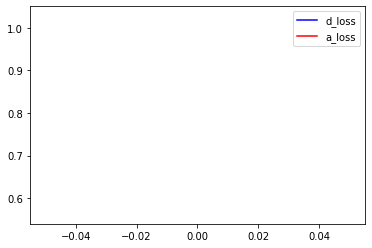

In [16]:
plt.plot([i[0] for i in logs][::10], 'b-', label='d_loss')
plt.plot([i[2] for i in logs][::10], 'r-', label='a_loss')
plt.legend()

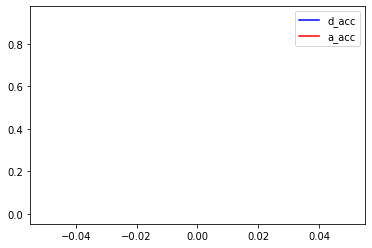

In [17]:
plt.plot([i[1] for i in logs][::10], 'b-', label='d_acc')
plt.plot([i[3] for i in logs][::10], 'r-', label='a_acc')
plt.legend()

In [18]:
! mkdir gan_images

하위 디렉터리 또는 파일 gan_images이(가) 이미 있습니다.


In [19]:
from keras.preprocessing import image

batch_size = 64
logs= []

In [20]:
for step in range(1000):
    indices = np.random.randint(0, len(X_train),size=batch_size)
    real_image =X_train[indices]
        
    gen_vectors = np.random.uniform(-1,1,size=[batch_size,100])
    fake_images = generator.predict(gen_vectors)
    
    X = np.r_[real_images,fake_images]
    y = np.r_[np.ones([batch_size,1]), np.zeros([batch_size,1])]
    
    d_loss, d_acc = discriminator.train_on_batch(X,y)
    
    gen_vectors_2 = np.random.uniform(-1,1, size=[batch_size,100])
    
    a_loss, a_acc = adversarial.train_on_batch(gen_vectors_2,np.ones([batch_size,1]))
    
    logs.append([d_loss,d_acc,a_loss,a_acc])
    print('Step: %05d, ' % (step+1), logs[-1])
    
    if (step+1)%10 == 0:
        
        img = image.array_to_img(fake_images[0]*255, scale= False)
        img.save('gan_image/fake_'+str(step+1)+'.png')        

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[ 0.42797967, -0.17640734, -0.67923813, ...,  0.34510732,
        -0.54497084,  0.27994231],
       [-0.0833857 , -0.2255967 ,  0.96361608, ...,  0.55016991,
        -0.71692912, -0.7806871 ],...